## Classroom exercise: the biggest earthquake in the UK this century

### The Problem

GeoJSON is a JSON-based file format for sharing geographic data. One example dataset is the USGS earthquake data:

In [1]:
import requests
quakes = requests.get("http://earthquake.usgs.gov/fdsnws/event/1/query.geojson",
                      params={
                          'starttime': "2000-01-01",
                          "maxlatitude": "58.723",
                          "minlatitude": "50.008",
                          "maxlongitude": "1.67",
                          "minlongitude": "-9.756",
                          "minmagnitude": "1",
                          "endtime": "2018-10-11",
                          "orderby": "time-asc"}
                      )

In [2]:
quakes.text[0:100]

'{"type":"FeatureCollection","metadata":{"generated":1572207437000,"url":"https://earthquake.usgs.gov'

Your exercise: determine the location of the largest magnitude earthquake in the UK this century.

You'll need to:
* Get the text of the web result
* Parse the data as JSON
* Understand how the data is structured into dictionaries and lists
   * Where is the magnitude?
   * Where is the place description or coordinates?
* Program a search through all the quakes to find the biggest quake
* Find the place of the biggest quake
* Form a URL for an online map service at that latitude and longitude: look back at the introductory example
* Display that image

In [3]:
# Parse JSON file
import json 
quakes_json = json.loads(quakes.text)
print(quakes_json.keys()) # get root keys for json 

# explore the structure of quakes_json by seeing what is under each key
print(len(quakes_json['features']), 'quakes\n') # 1 feature = 1 quake
print('Structure of each feature:')
quakes_json['features'][0]

dict_keys(['type', 'metadata', 'features', 'bbox'])
120 quakes

Structure of each feature:


{'type': 'Feature',
 'properties': {'mag': 2.6,
  'place': 'England, United Kingdom',
  'time': 956553055700,
  'updated': 1415322596133,
  'tz': None,
  'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/usp0009rst',
  'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=usp0009rst&format=geojson',
  'felt': None,
  'cdi': None,
  'mmi': None,
  'alert': None,
  'status': 'reviewed',
  'tsunami': 0,
  'sig': 104,
  'net': 'us',
  'code': 'p0009rst',
  'ids': ',usp0009rst,',
  'sources': ',us,',
  'types': ',impact-text,origin,phase-data,',
  'nst': None,
  'dmin': None,
  'rms': None,
  'gap': None,
  'magType': 'ml',
  'type': 'earthquake',
  'title': 'M 2.6 - England, United Kingdom'},
 'geometry': {'type': 'Point', 'coordinates': [-2.81, 54.77, 14]},
 'id': 'usp0009rst'}

In [4]:
import matplotlib.pyplot as plt
import imageio
import pandas as pd

# Stage 1: find the largest magnitude earthquakes 

# put list of Earthquakes in df
df = pd.DataFrame(quakes_json['features'])

# unpack the 'properties' and the 'geometry' columns and concat into one df
df1 = df['properties'].apply(pd.Series)
df2 = df['geometry'].apply(pd.Series)
df = pd.concat([df1, df2], axis=1)

# Only keep the time, place, coordinates and magnitude columns
df = df.set_index(df.ids)
df = df[['time','place','coordinates','mag']]

# locate the rows with max magnitude
df_max = df.loc[df['mag'] == max(df['mag'])]
df_max

,time,place,coordinates,mag
ids,,,,
",usp000bcxg,atlas20020922235314,",1032738794600,"England, United Kingdom","[-2.15, 52.52, 9.4]",4.8
",us2008nyae,usp000g02w,atlas20080227005647,",1204073807800,"England, United Kingdom","[-0.332, 53.403, 18.4]",4.8


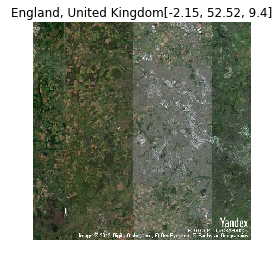

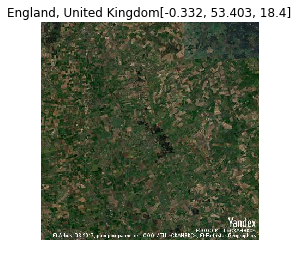

In [5]:
# Open location of the largest quake in static map
import requests

def request_map_at(lat, long, satellite=True,
                   zoom=10, size=(400, 400)):
    base = "https://static-maps.yandex.ru/1.x/?"

    params = dict(
        z=zoom,
        size="{},{}".format(size[0], size[1]),
        ll="{},{}".format(long, lat),
        l="sat" if satellite else "map",
        lang="en_US"
    )

    return requests.get(base, params=params)   

# plotting the max magnitude earthquakes on a map
for index, row in df_max.iterrows():
    long = row['coordinates'][0]
    lat = row['coordinates'][1]
    map_uri = request_map_at(lat, long)
    map_bytes = map_uri.content
    # Convert image from bytes to image and display it
    im = imageio.imread(map_bytes)
    plt.figure()
    plt.imshow(im)
    plt.title(row['place']+str(row['coordinates']))
    plt.axis('off')

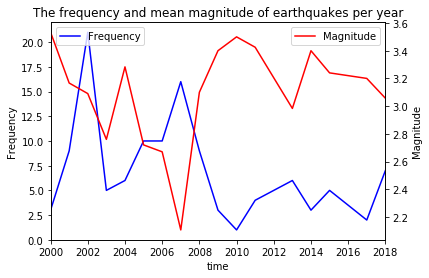

In [6]:
# Stage 3: the frequency (number) of earthquakes per year
#          the average magnitude of earthquakes per year   
#
# put list of Earthquakes in df
df = pd.DataFrame(quakes_json['features'])
df = df.set_index(df.id)
df = df['properties'].apply(pd.Series)

# convert epoch time to readable datetime
df['time'] = pd.to_datetime(df['time'], unit='ms')

# create a figure with two y-axis
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('The frequency and mean magnitude of earthquakes per year')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Magnitude')

# To get number of quakes per year; group by 'year' and aggregate with 'count' method
df['time'].groupby([df.time.dt.year]).agg('count').plot(ax=ax1, style='b-', label='Frequency')

# To get mean magnitude per year; group by 'year' and aggregate with 'mean' method
df['mag'].groupby([df.time.dt.year]).agg('mean').plot(ax=ax2, style='r-', label='Magnitude')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')